### Import libraries and datasets:

In [60]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [61]:
csv_fts = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\FTS Historical Data.csv"
csv_mwg = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\MWG Historical Data.csv"
csv_vic = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\VIC Historical Data.csv"



df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [62]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


- Split Price data
- Reset index

In [63]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788.4
1,5953.7
2,6024.6
3,5882.9
4,6001.0


- Scale data between 0 and 1:

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003587
2,0.005125
3,0.002051
4,0.004613


- Split data into train, test, val (7 - 2 - 1):

In [65]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


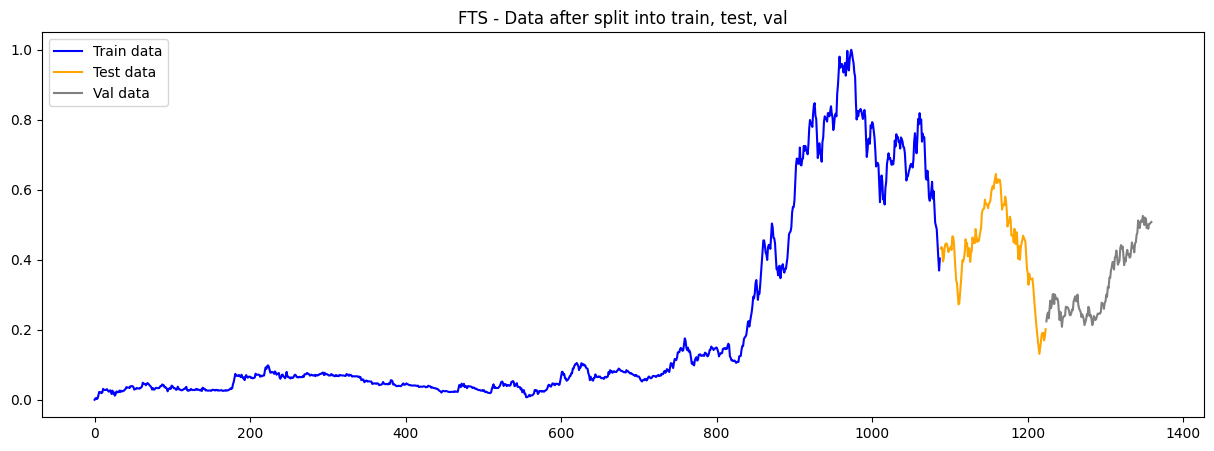

In [66]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [67]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [68]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

Kernel: linear, poly, rbf, sigmoid, precomputed

In [69]:
model_svr = SVR(kernel='poly')
model_svr.fit(x_train, y_train)

SVR(kernel='poly')

- Model Prediction on test, val (one-step prediction):

In [70]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [71]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [72]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[15606.2994403 ],
       [13702.68281371],
       [15736.3355474 ],
       [17692.71375121],
       [18471.60425983],
       [18129.39996995],
       [17803.8077437 ],
       [17561.58912962],
       [17771.90695567],
       [17444.04878234],
       [16935.94482227],
       [16544.00806082],
       [15871.80317735],
       [15664.47586694],
       [16156.00474357],
       [16025.14306758],
       [16184.01336967],
       [16103.86015856],
       [16608.45961226],
       [16936.69523934],
       [16529.95342651],
       [15656.99177501],
       [14408.48720936],
       [13846.63431513],
       [13604.43546413],
       [14178.3691566 ],
       [14105.65410905],
       [13608.30704827],
       [12981.87625399],
       [12441.88402117]])

- Model evaluating (RMSE - MAPE - MSLE):

In [73]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 19726.6012
Validating RMSE: 14899.1653
Predicting 30 days RMSE: 15893.2117

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 90.3801
Validating MSLE: 86.2558
Predicting 30 days MSLE: 85.9885


- Prediction plotting:

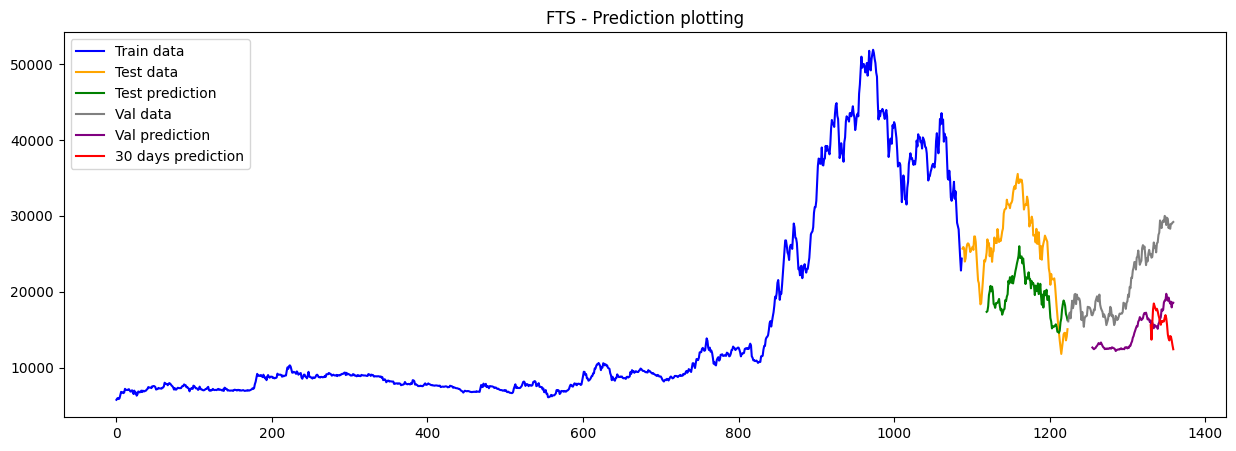

In [74]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [75]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


- Split Price data
- Reset index

In [76]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [77]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [78]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


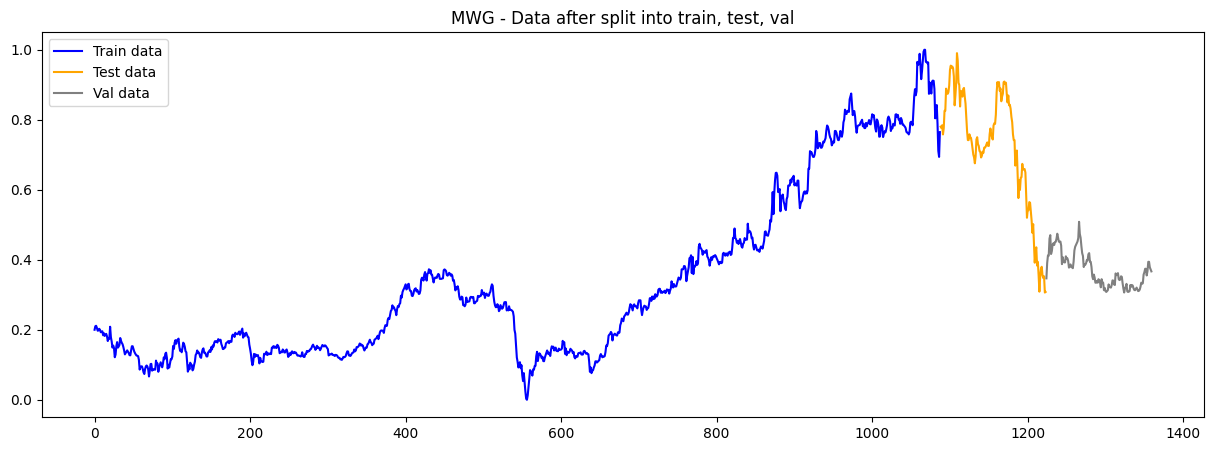

In [79]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [80]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [81]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

In [82]:
model_svr = SVR(kernel='poly')
model_svr.fit(x_train, y_train)

SVR(kernel='poly')

- Model Prediction on test, val (one-step prediction):

In [83]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [84]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [85]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[34634.62768454],
       [33581.48141905],
       [33085.07276169],
       [32449.42171245],
       [31964.76852055],
       [31105.1393758 ],
       [30173.38864472],
       [29788.36898134],
       [29012.37009402],
       [28524.78614492],
       [28211.32328973],
       [27949.87089549],
       [27231.11242893],
       [26549.07058618],
       [26188.92675806],
       [26131.20331206],
       [26165.36273186],
       [26445.45124365],
       [26725.68334146],
       [26964.34338073],
       [27482.63754331],
       [28020.89855362],
       [28843.47587287],
       [29607.52916819],
       [30045.43304198],
       [30288.12074687],
       [30698.03942471],
       [31114.51044403],
       [31617.2575024 ],
       [31980.93315477]])

- Model evaluating (RMSE - MAPE - MSLE):

In [86]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 54471.0949
Validating RMSE: 35818.3724
Predicting 30 days RMSE: 29516.2185

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 104.4658
Validating MSLE: 103.6299
Predicting 30 days MSLE: 99.8902


- Prediction plotting:

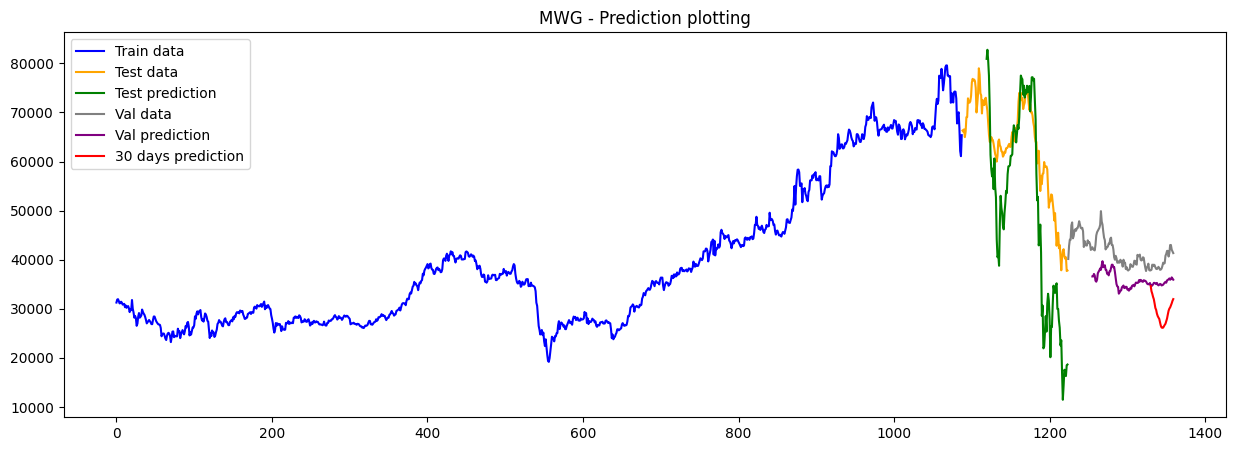

In [87]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [88]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [89]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [90]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [91]:
train_size = int(0.8 * len(df_price))
test_size = int(0.1 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1088, 1)
(136, 1)
(136, 1)


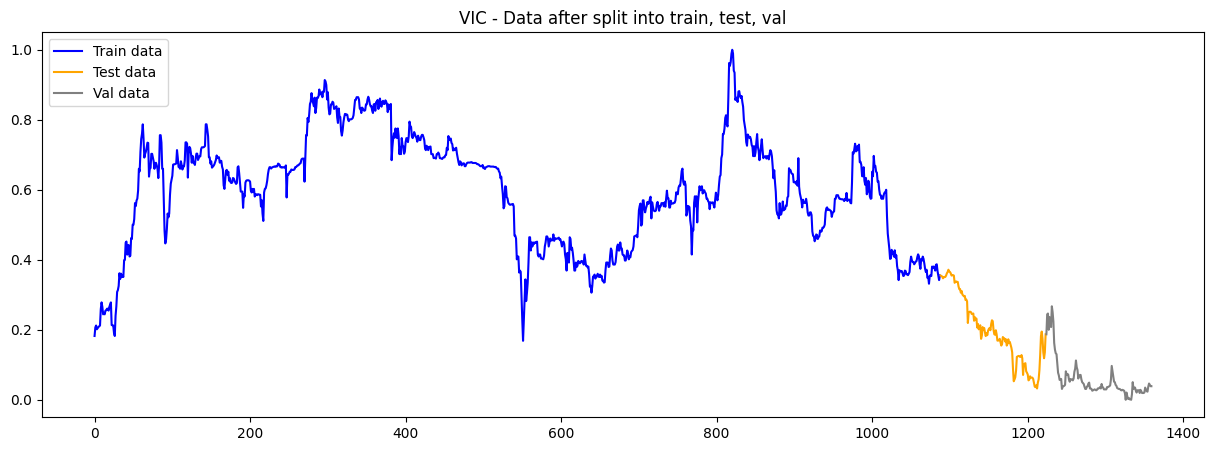

In [92]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [93]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)] 
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [94]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Model training:

In [95]:
model_svr = SVR(kernel='poly')
model_svr.fit(x_train, y_train)

SVR(kernel='poly')

- Model Prediction on test, val (one-step prediction):

In [96]:
y_pred_test = model_svr.predict(x_test)
y_pred_val = model_svr.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

- 30 days prediction:

In [97]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags)
    y_hat = model_svr.predict(x_input)
    temp_input.append(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.append(y_hat[0])
    i += 1


In [98]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[ 81209.48101859],
       [ 81576.96901547],
       [ 81619.58229971],
       [ 82016.56474661],
       [ 83278.81430382],
       [ 85404.18640196],
       [ 84756.35479763],
       [ 86278.88288902],
       [ 88279.98492804],
       [ 89485.52398491],
       [ 93286.78679006],
       [ 93372.52032968],
       [ 98660.20358545],
       [ 97663.09508275],
       [ 95677.19787883],
       [ 89413.27360412],
       [ 87327.05306651],
       [ 89053.04727092],
       [ 81046.22603847],
       [ 87359.68612457],
       [ 88480.88347606],
       [ 96718.95320867],
       [ 90788.57326984],
       [ 93630.70590615],
       [ 96254.04233503],
       [ 93046.438421  ],
       [ 92204.38874269],
       [101506.55609967],
       [ 98971.30568954],
       [109826.27288527]])

- Model evaluating (RMSE - MAPE - MSLE):

In [99]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 81537.2524
Validating RMSE: 81232.9301
Predicting 30 days RMSE: 90861.0438

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 124.6242
Validating MSLE: 126.9685
Predicting 30 days MSLE: 129.6525


- Prediction plotting:

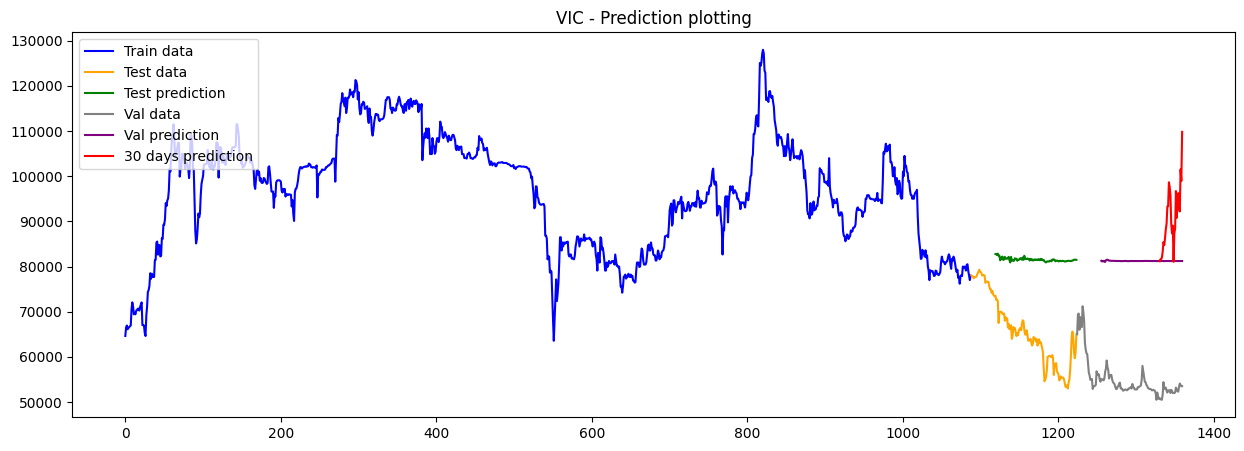

In [100]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()